In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,7,8,9'

In [1]:
from compass import ScoreBasedInferenceModel as SBIm

In [2]:

import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import seaborn as sns

import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas as pd

from scipy.stats import norm, gaussian_kde
from scipy import optimize

import os

In [3]:
def gen_data(int):
    theta1 = torch.randn(int) * 3
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [4]:
theta, x = gen_data(10_000)

val_theta, val_x = gen_data(1000)

nodes_max = theta.shape[1] + x.shape[1]

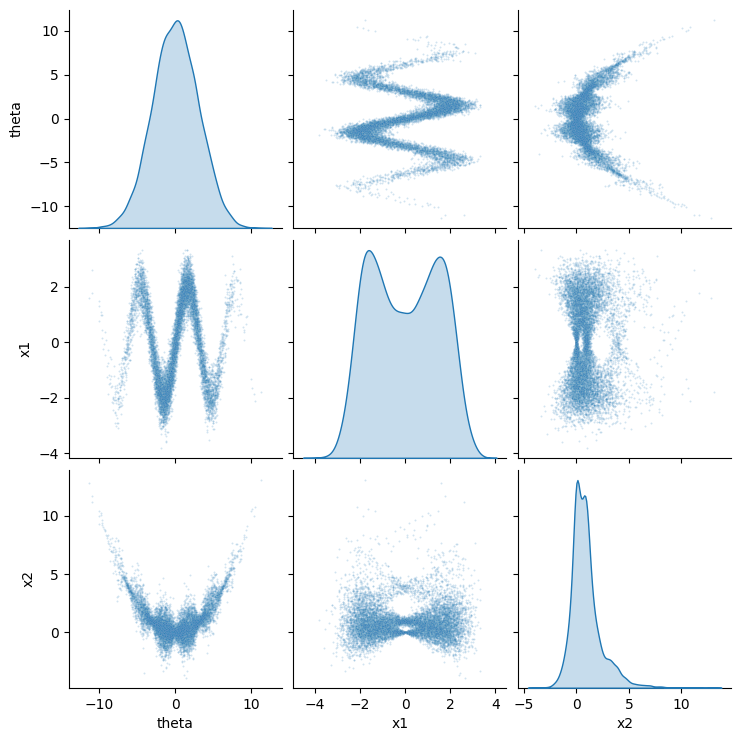

In [5]:
df = pd.DataFrame(torch.concatenate([theta, x], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
sns.pairplot(df, diag_kind='kde', plot_kws=dict(alpha=0.2, s=2))
plt.show()

In [6]:
model = SBIm(nodes_max, sigma=10, depth=4, num_heads=4, hidden_size=64)

In [7]:
model.train(theta=theta, x=x, theta_val=val_theta, x_val=val_x, verbose=False, device='cuda:8', batch_size=64) 

KeyboardInterrupt: 

In [8]:
path = "data/models/Model_test/Model_checkpoint.pt"
model = SBIm.load(path)

In [9]:
# epoch = np.arange(0, len(model.trainer.train_loss))

# plt.plot(epoch, np.array(model.trainer.train_loss), label='Train Loss')
# plt.plot(epoch, np.array(model.trainer.val_loss), label='Val Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

In [25]:
s = model.sample(num_samples=10000, method="euler", device="cuda", timesteps=1000)

100%|██████████| 1/1 [00:20<00:00, 20.41s/it]


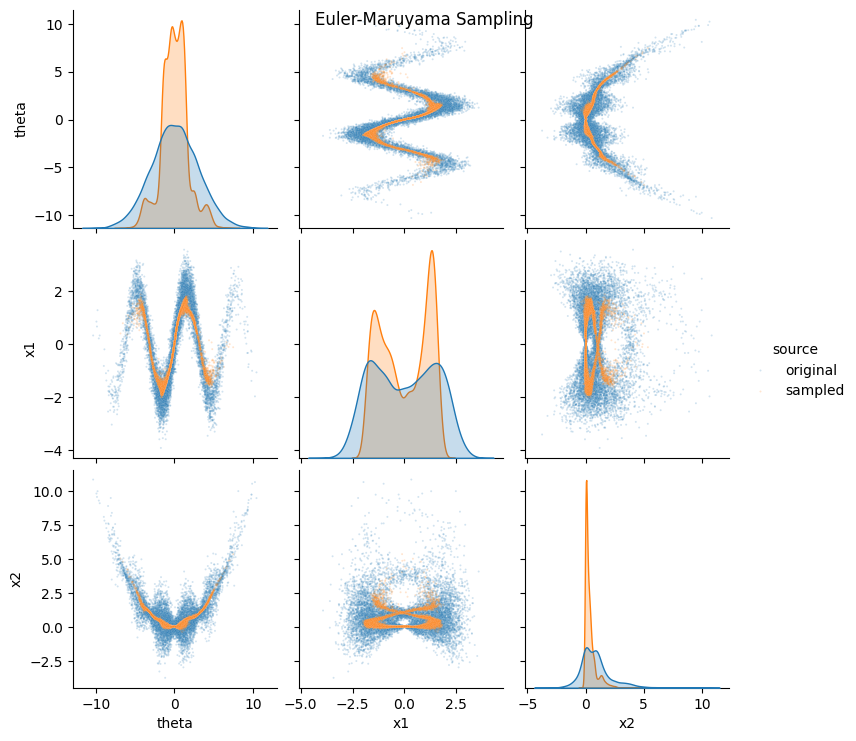

In [26]:
df_euler = pd.DataFrame(s.permute(2,1,0).flatten(1).T.cpu().numpy(), columns=['theta', 'x1', 'x2'])

df['source'] = 'original'
df_euler['source'] = 'sampled'

df_combined = pd.concat([df, df_euler], axis=0)

pp = sns.pairplot(df_combined, hue='source', diag_kind='kde', diag_kws=dict(common_norm=False), plot_kws=dict(alpha=0.2, s=2))
pp.fig.suptitle("Euler-Maruyama Sampling")
plt.show()

In [34]:
s = model.sample(num_samples=10000, method="dpm", device="cuda", timesteps=1000, order=1, final_corrector_steps=10, corrector_steps_interval=5, corrector_steps=5, snr=0.1)

100%|██████████| 1/1 [00:43<00:00, 43.29s/it]


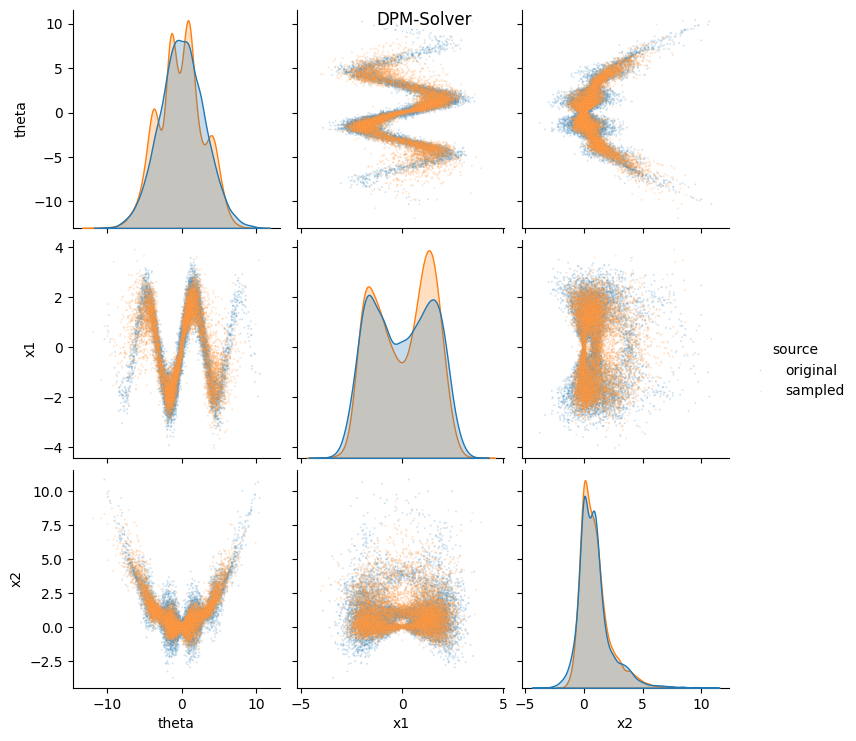

In [35]:
df_dpm = pd.DataFrame(s.permute(2,1,0).flatten(1).T.cpu().numpy(), columns=['theta', 'x1', 'x2'])

df['source'] = 'original'
df_dpm['source'] = 'sampled'

df_combined = pd.concat([df, df_dpm], axis=0)

pp = sns.pairplot(df_combined, hue='source', diag_kind='kde', diag_kws=dict(common_norm=False), plot_kws=dict(alpha=0.2, s=2))
pp.fig.suptitle("DPM-Solver")
plt.show()

In [15]:
posterior=gaussian_kde(s.permute(2,1,0).flatten(1).cpu().numpy())

In [16]:
posterior.pdf([0,0,0])

array([0.01611743])

In [17]:
def map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    s = samples.numpy()
    kde = gaussian_kde(s)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(s, axis=1)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    std_devs = np.sqrt(np.diag(kde.covariance))

    return result.x, std_devs

In [18]:
map_kde(s.permute(2,1,0).flatten(1).cpu())

(array([1.08993928, 1.24252172, 0.24996776]),
 array([1.10667042, 0.53415032, 0.47916586]))

In [19]:
posterior.pdf(map_kde(s.permute(2,1,0).flatten(1).cpu())[0])

array([0.02599745])

In [20]:
def map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    s = samples.numpy()
    kde = gaussian_kde(s.T)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(s, axis=0)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    std_devs = np.sqrt(np.diag(kde.covariance))

    return result.x, std_devs

In [21]:
s.shape

torch.Size([1, 1000, 3])

In [22]:
map0, std0 = map_kde(s.permute(2,1,0).flatten(1).cpu().T)
print(map0)
print(std0)

[1.08993928 1.24252172 0.24996776]
[1.10667042 0.53415032 0.47916586]
